# 03 - Kernel Density Estimation (KDE) Analysis

This notebook performs spatial density analysis using Kernel Density Estimation to identify earthquake hotspots and high-risk areas.

## Contents
1. Setup and Data Loading
2. Basic KDE Analysis
3. KDE by Magnitude Category
4. KDE by Time Period
5. KDE by Depth
6. Comparison with Fault Lines
7. Risk Hotspot Identification

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from visualization import setup_style, create_turkey_basemap, plot_fault_lines
from geo_utils import create_turkey_grid

setup_style()

# Create output directory
OUTPUT_DIR = os.path.join(FIGURES_PATH, '03_kde')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')
fault_df = pd.read_csv(FAULT_DATA)

print(f"Loaded {len(eq_df):,} seismic events")
print(f"Loaded {len(fault_df)} fault segments")

# Import Turkey map functions for province boundaries
import sys
sys.path.insert(0, '../src')
from visualization import load_turkey_provinces
turkey_gdf = load_turkey_provinces()


Loaded 524,952 seismic events
Loaded 20 fault segments


## 2. Basic KDE Analysis

In [2]:
def compute_kde(lons, lats, resolution=100, bw_method='scott'):
    """
    Compute 2D Kernel Density Estimation.
    
    Parameters
    ----------
    lons, lats : array-like
        Coordinates of events
    resolution : int
        Grid resolution
    bw_method : str or float
        Bandwidth selection method ('scott', 'silverman', or scalar)
    
    Returns
    -------
    Xi, Yi, Zi : arrays
        Grid coordinates and density values
    kde : scipy.stats.gaussian_kde
        The fitted KDE object
    """
    positions = np.vstack([lons, lats])
    kde = gaussian_kde(positions, bw_method=bw_method)
    
    # Create evaluation grid
    xi = np.linspace(TURKEY_BOUNDS['lon_min'], TURKEY_BOUNDS['lon_max'], resolution)
    yi = np.linspace(TURKEY_BOUNDS['lat_min'], TURKEY_BOUNDS['lat_max'], resolution)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Evaluate KDE
    Zi = kde(np.vstack([Xi.ravel(), Yi.ravel()])).reshape(Xi.shape)
    
    return Xi, Yi, Zi, kde

print("KDE function defined.")

KDE function defined.


In [3]:
# Compute KDE for all events
print("Computing KDE for all seismic events...")
Xi, Yi, Zi_all, kde_all = compute_kde(
    eq_df['longitude'].values, 
    eq_df['latitude'].values,
    resolution=150
)
print(f"KDE computed. Max density: {Zi_all.max():.6f}")

Computing KDE for all seismic events...


KDE computed. Max density: 0.114653


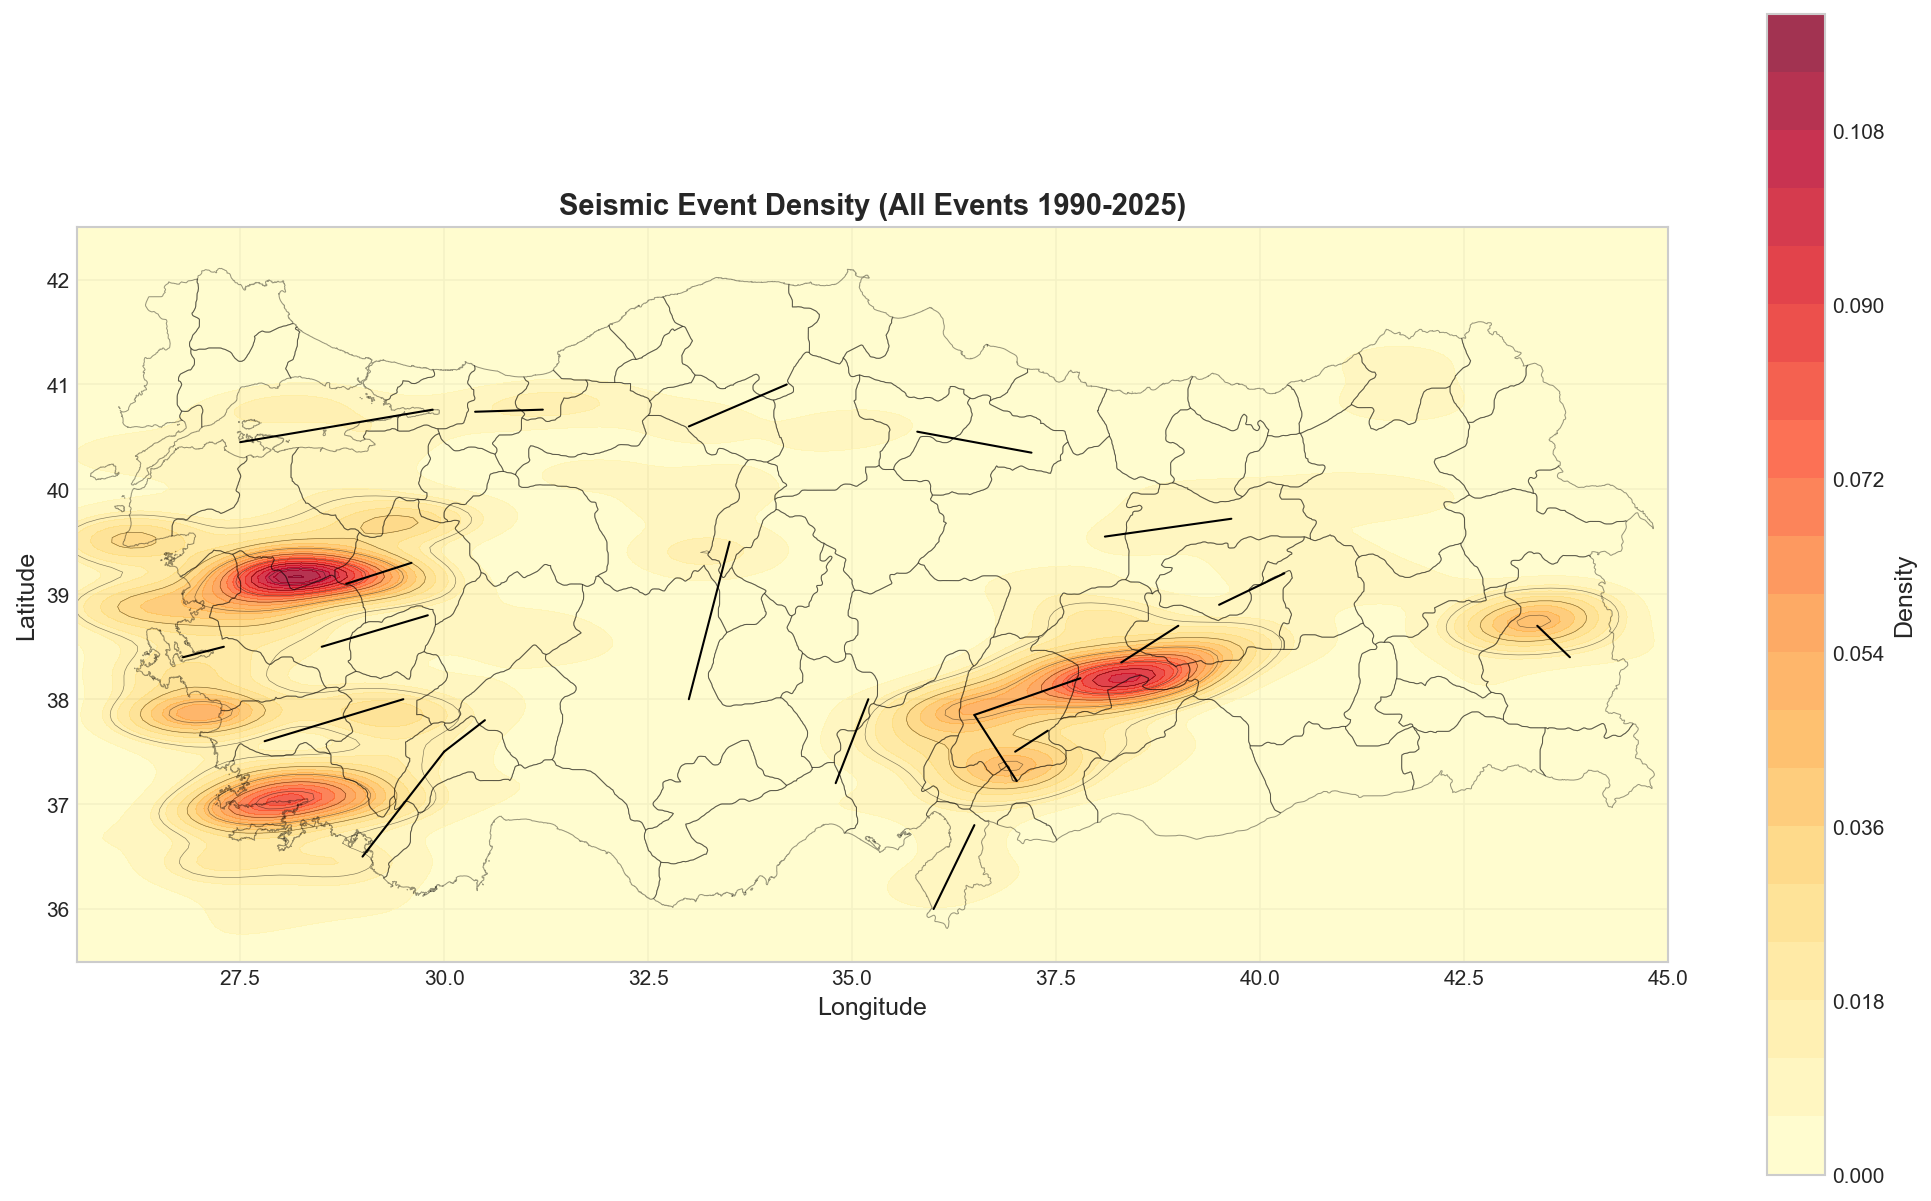

In [4]:
# Plot KDE - All events
fig, ax = plt.subplots(figsize=(14, 10))

ax = create_turkey_basemap(ax, 'Seismic Event Density (All Events 1990-2025)')

# Filled contours
contour = ax.contourf(Xi, Yi, Zi_all, levels=20, cmap=DENSITY_CMAP, alpha=0.8)
turkey_gdf.boundary.plot(ax=ax, linewidth=0.5, color='black', alpha=0.4, zorder=3)
plt.colorbar(contour, ax=ax, label='Density', shrink=0.8)

# Add contour lines
ax.contour(Xi, Yi, Zi_all, levels=10, colors='black', linewidths=0.3, alpha=0.5)

# Add fault lines
plot_fault_lines(fault_df, ax=ax, color='black', linewidth=1, label=False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kde_all_events.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. KDE by Magnitude Category

In [5]:
# Separate earthquakes and tremors
earthquakes = eq_df[eq_df['category'] == 'Earthquake']
tremors = eq_df[eq_df['category'] == 'Tremor']

print(f"Earthquakes (M >= 4.0): {len(earthquakes):,}")
print(f"Tremors (M < 4.0): {len(tremors):,}")

Earthquakes (M >= 4.0): 4,103
Tremors (M < 4.0): 520,849


In [6]:
# Compute KDE for each category
print("Computing KDE for earthquakes...")
Xi, Yi, Zi_eq, kde_eq = compute_kde(
    earthquakes['longitude'].values,
    earthquakes['latitude'].values,
    resolution=100
)

print("Computing KDE for tremors...")
Xi, Yi, Zi_tr, kde_tr = compute_kde(
    tremors['longitude'].values,
    tremors['latitude'].values,
    resolution=100
)

Computing KDE for earthquakes...


Computing KDE for tremors...


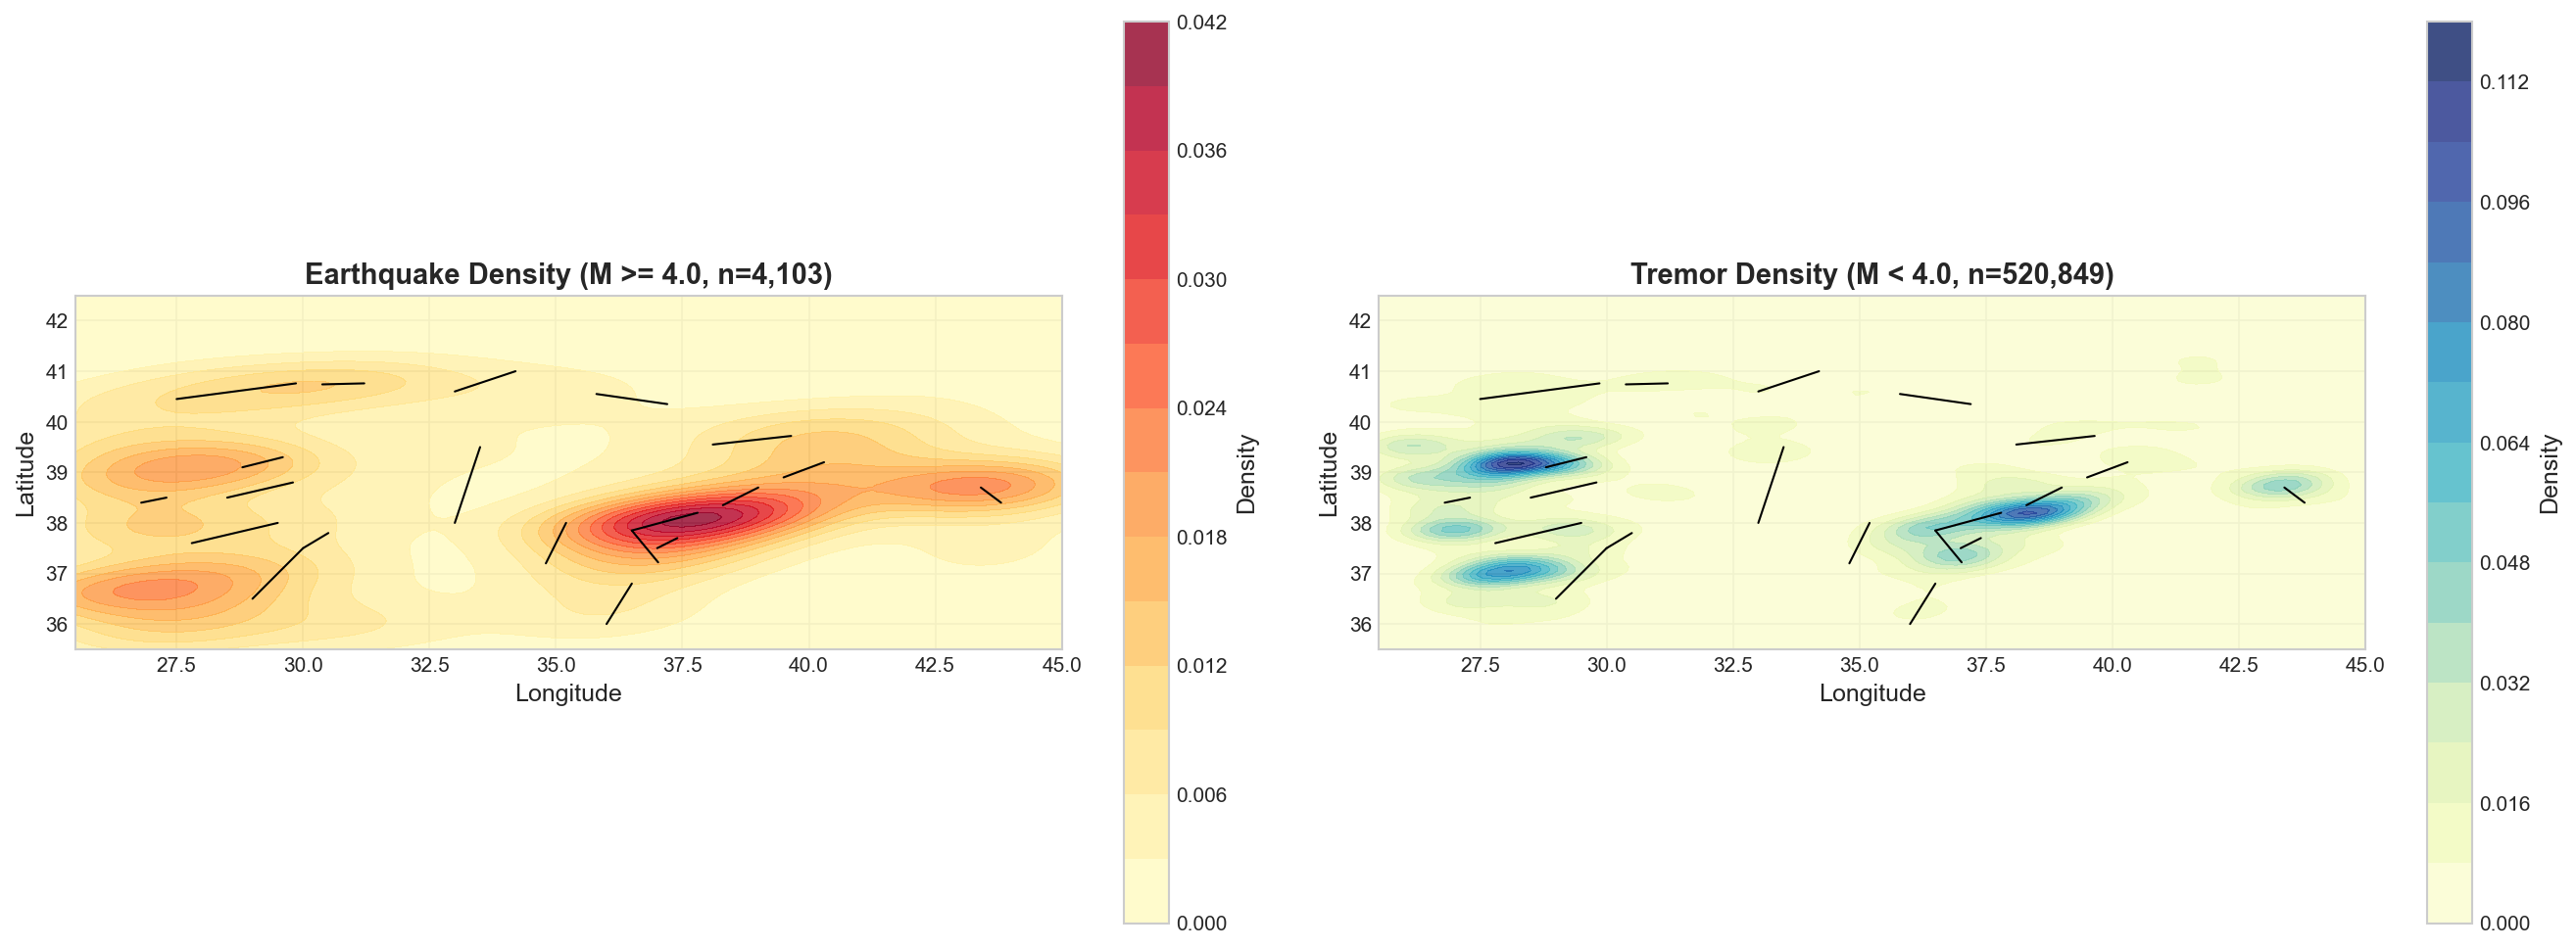

In [7]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Earthquakes
ax1 = create_turkey_basemap(axes[0], f'Earthquake Density (M >= 4.0, n={len(earthquakes):,})')
c1 = ax1.contourf(Xi, Yi, Zi_eq, levels=15, cmap='YlOrRd', alpha=0.8)
plt.colorbar(c1, ax=ax1, label='Density', shrink=0.8)
plot_fault_lines(fault_df, ax=ax1, color='black', linewidth=1, label=False)

# Tremors
ax2 = create_turkey_basemap(axes[1], f'Tremor Density (M < 4.0, n={len(tremors):,})')
c2 = ax2.contourf(Xi, Yi, Zi_tr, levels=15, cmap='YlGnBu', alpha=0.8)
plt.colorbar(c2, ax=ax2, label='Density', shrink=0.8)
plot_fault_lines(fault_df, ax=ax2, color='black', linewidth=1, label=False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kde_by_category.png'), dpi=150, bbox_inches='tight')
plt.show()

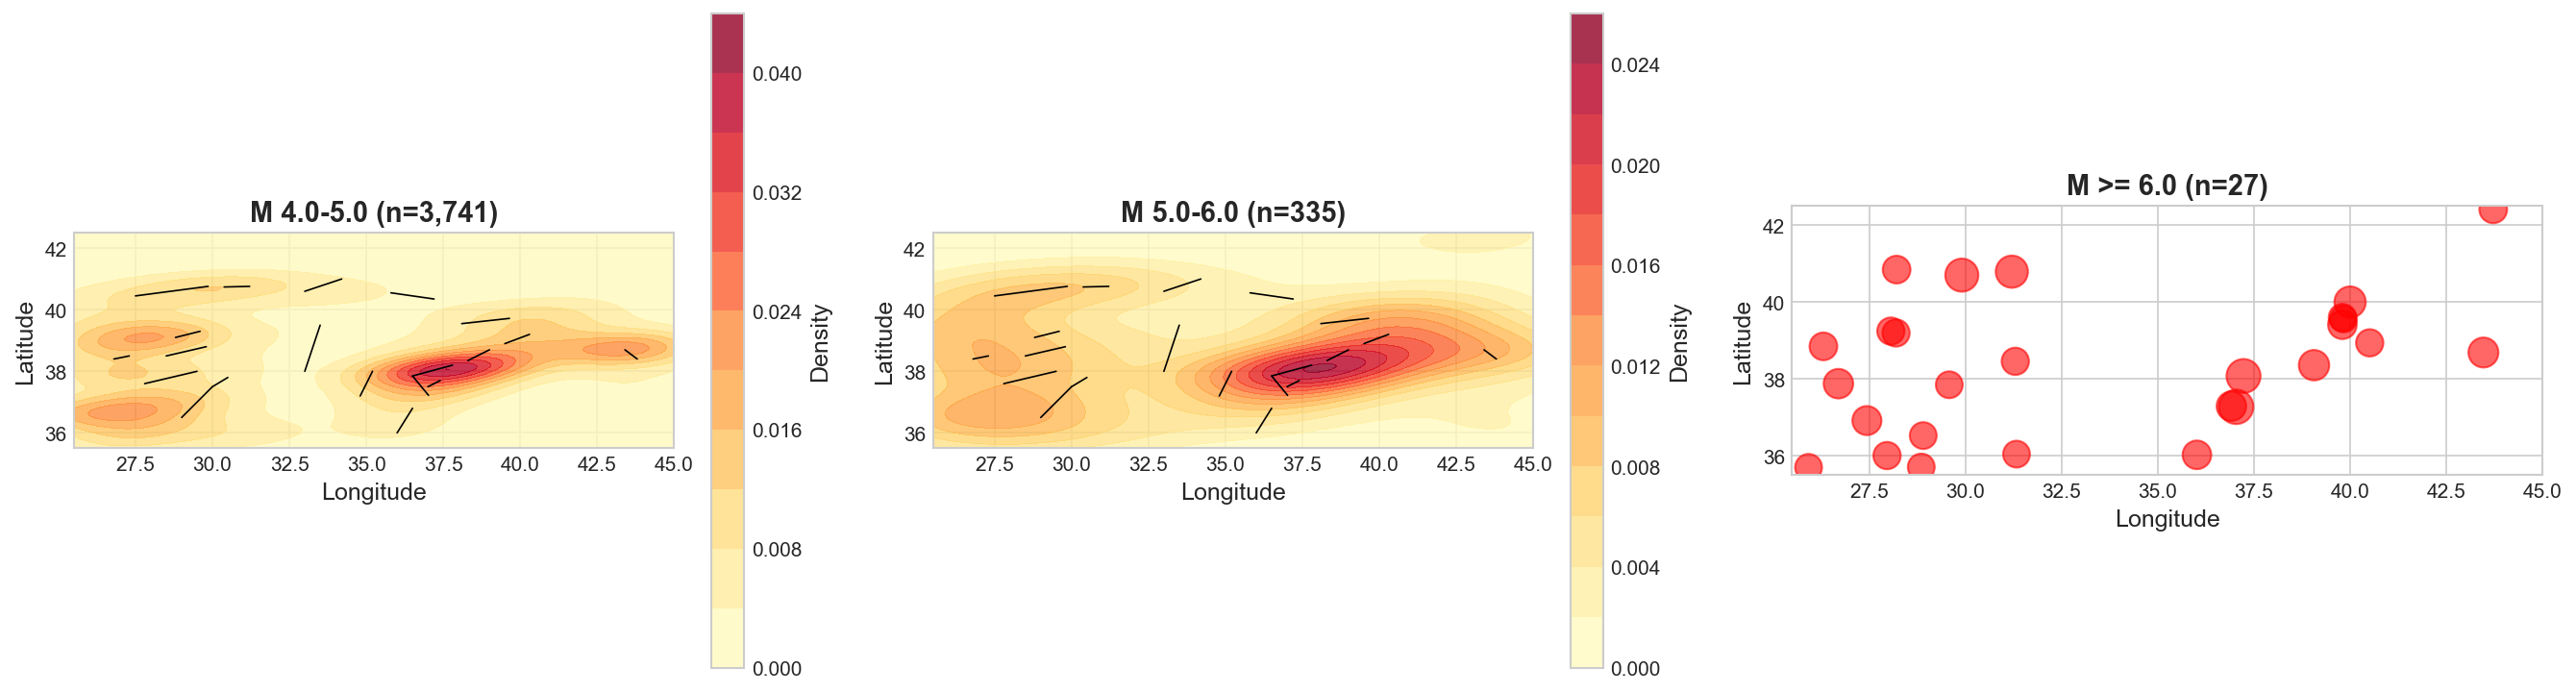

In [8]:
# KDE for different magnitude ranges
magnitude_ranges = [
    (4.0, 5.0, 'M 4.0-5.0'),
    (5.0, 6.0, 'M 5.0-6.0'),
    (6.0, 10.0, 'M >= 6.0')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (m_min, m_max, label) in zip(axes, magnitude_ranges):
    subset = eq_df[(eq_df['magnitude'] >= m_min) & (eq_df['magnitude'] < m_max)]
    
    if len(subset) > 100:  # Need minimum points for KDE
        Xi, Yi, Zi, _ = compute_kde(
            subset['longitude'].values,
            subset['latitude'].values,
            resolution=80
        )
        
        ax = create_turkey_basemap(ax, f'{label} (n={len(subset):,})')
        c = ax.contourf(Xi, Yi, Zi, levels=12, cmap='YlOrRd', alpha=0.8)
        plt.colorbar(c, ax=ax, label='Density', shrink=0.8)
        plot_fault_lines(fault_df, ax=ax, color='black', linewidth=0.8, label=False)
    else:
        ax = create_turkey_basemap(ax, f'{label} (n={len(subset):,})')
        ax.scatter(subset['longitude'], subset['latitude'], 
                   s=subset['magnitude']**2 * 5, c='red', alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kde_by_magnitude_range.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. KDE by Time Period

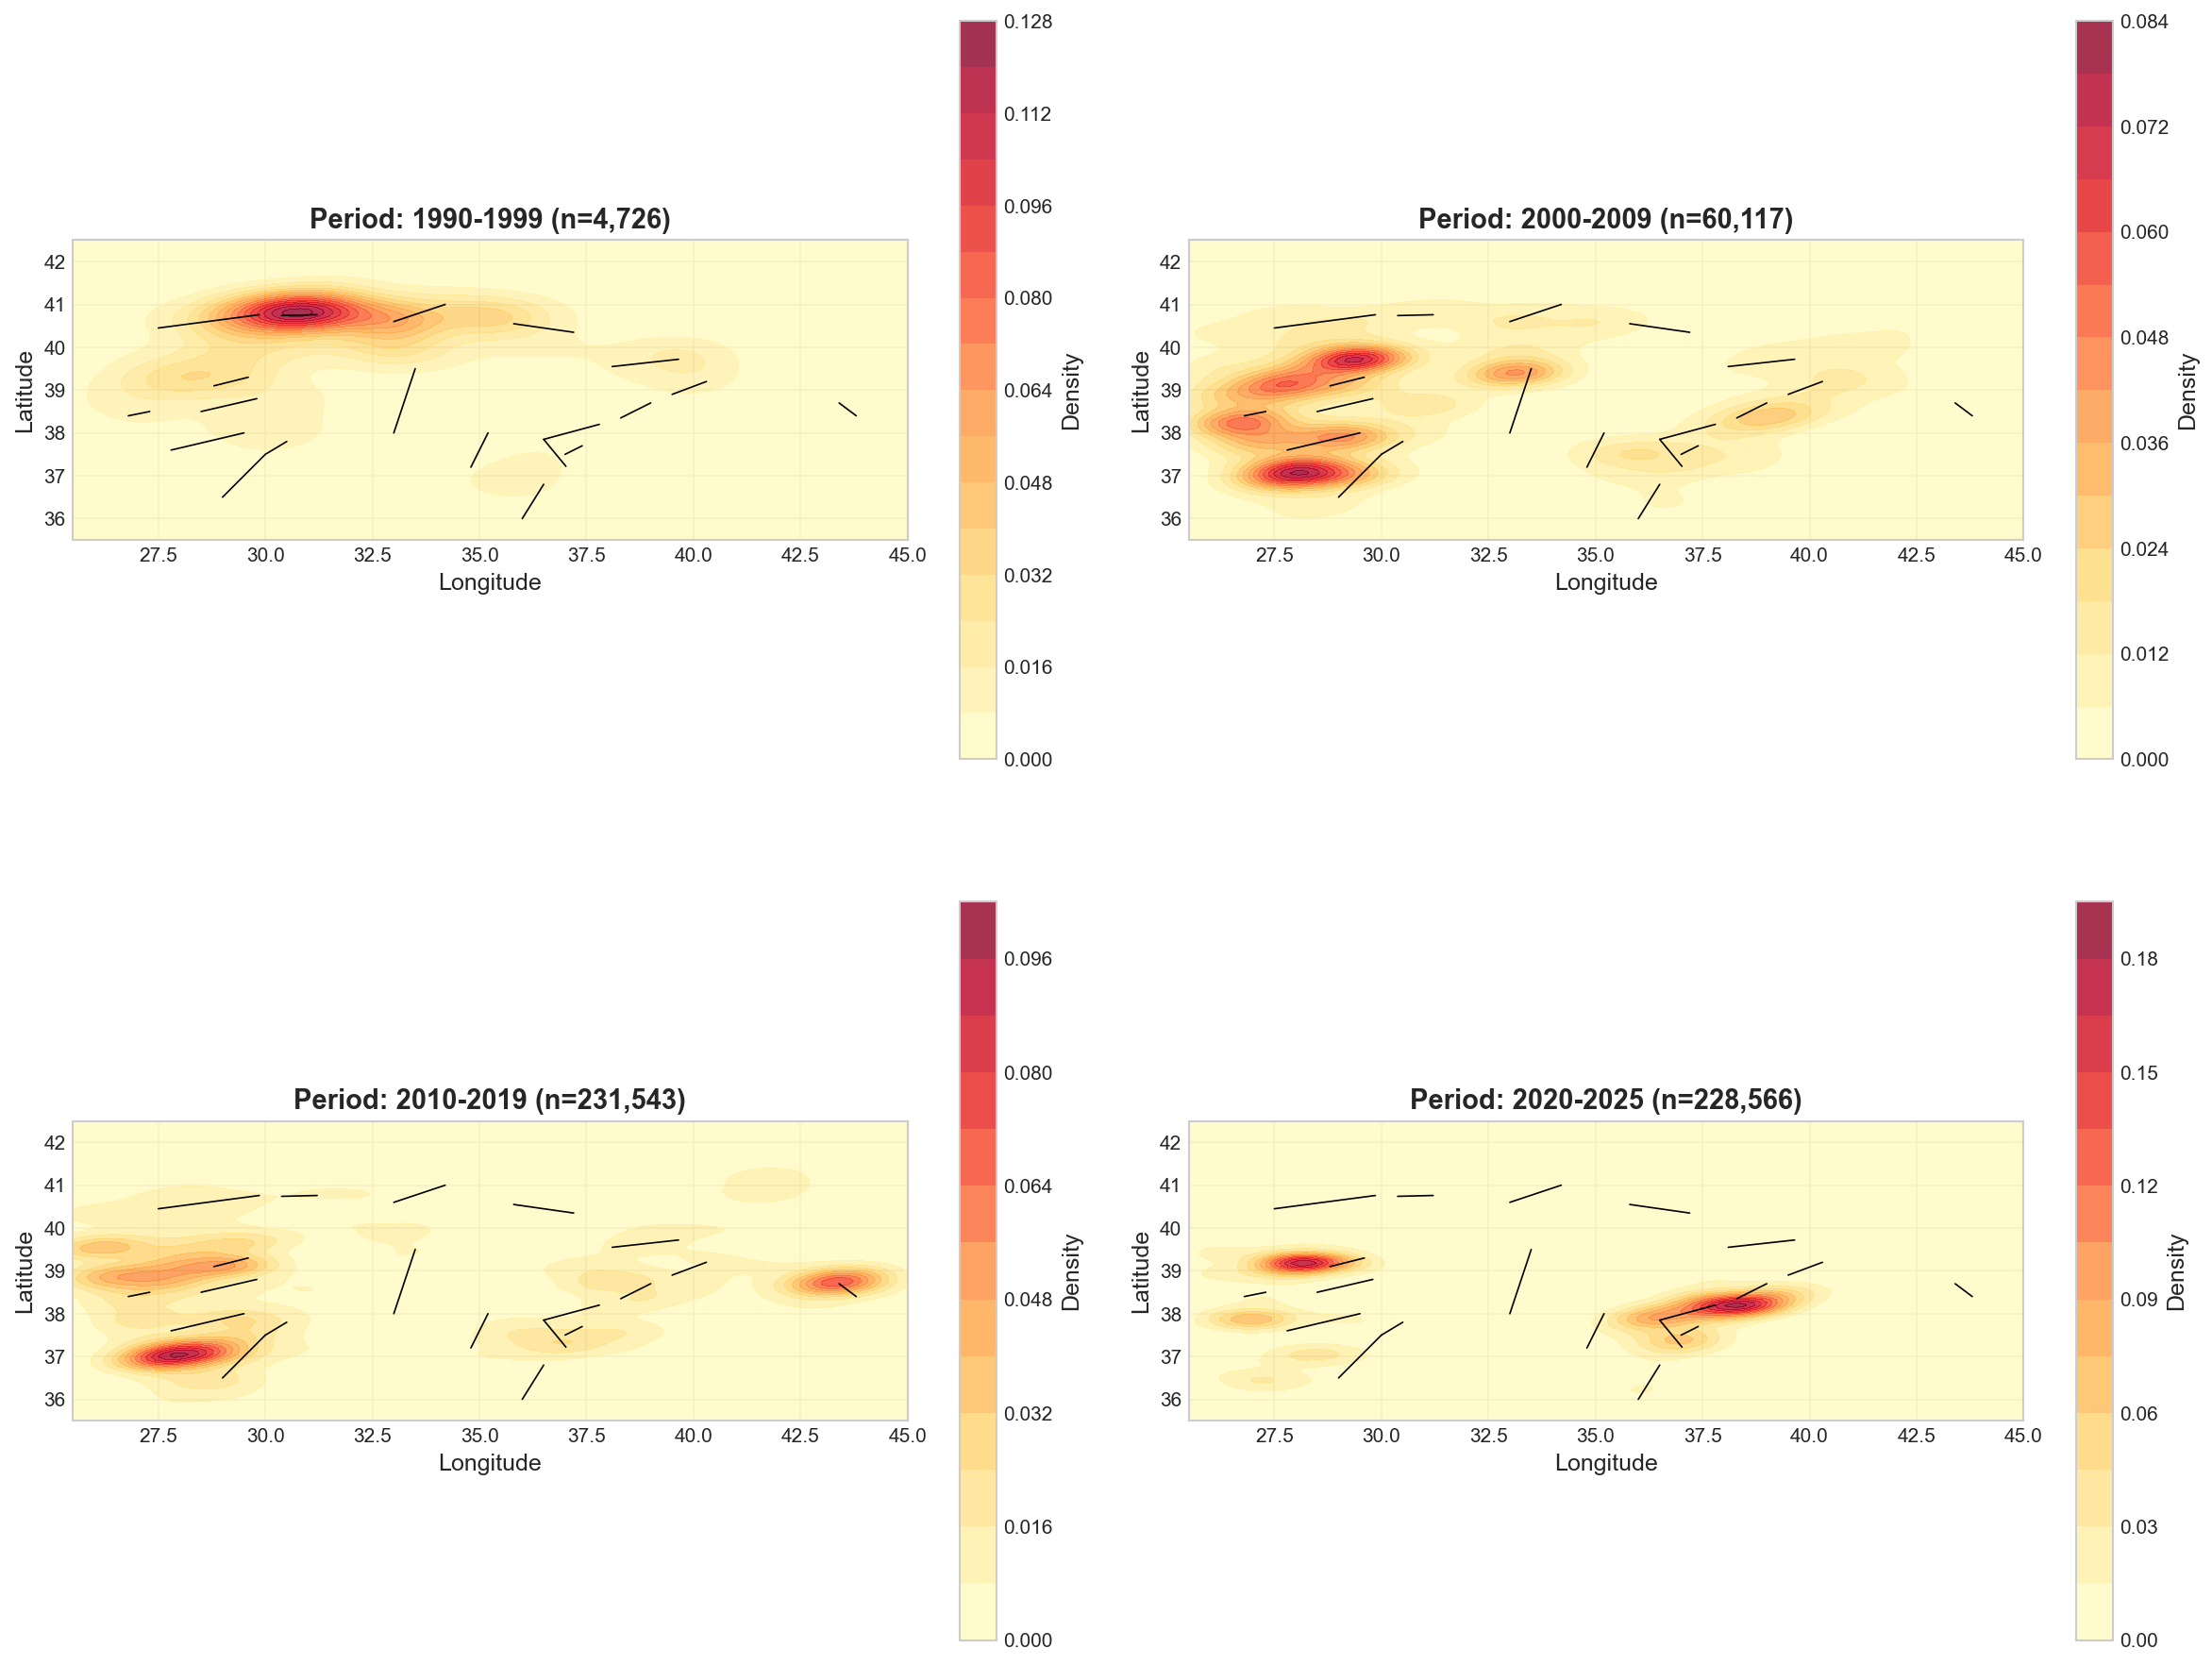

In [9]:
# Define time periods
time_periods = [
    (1990, 2000, '1990-1999'),
    (2000, 2010, '2000-2009'),
    (2010, 2020, '2010-2019'),
    (2020, 2026, '2020-2025')
]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for ax, (y_start, y_end, label) in zip(axes, time_periods):
    subset = eq_df[(eq_df['year'] >= y_start) & (eq_df['year'] < y_end)]
    
    Xi, Yi, Zi, _ = compute_kde(
        subset['longitude'].values,
        subset['latitude'].values,
        resolution=100
    )
    
    ax = create_turkey_basemap(ax, f'Period: {label} (n={len(subset):,})')
    c = ax.contourf(Xi, Yi, Zi, levels=15, cmap=DENSITY_CMAP, alpha=0.8)
    plt.colorbar(c, ax=ax, label='Density', shrink=0.7)
    plot_fault_lines(fault_df, ax=ax, color='black', linewidth=0.8, label=False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kde_by_time_period.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. KDE by Depth

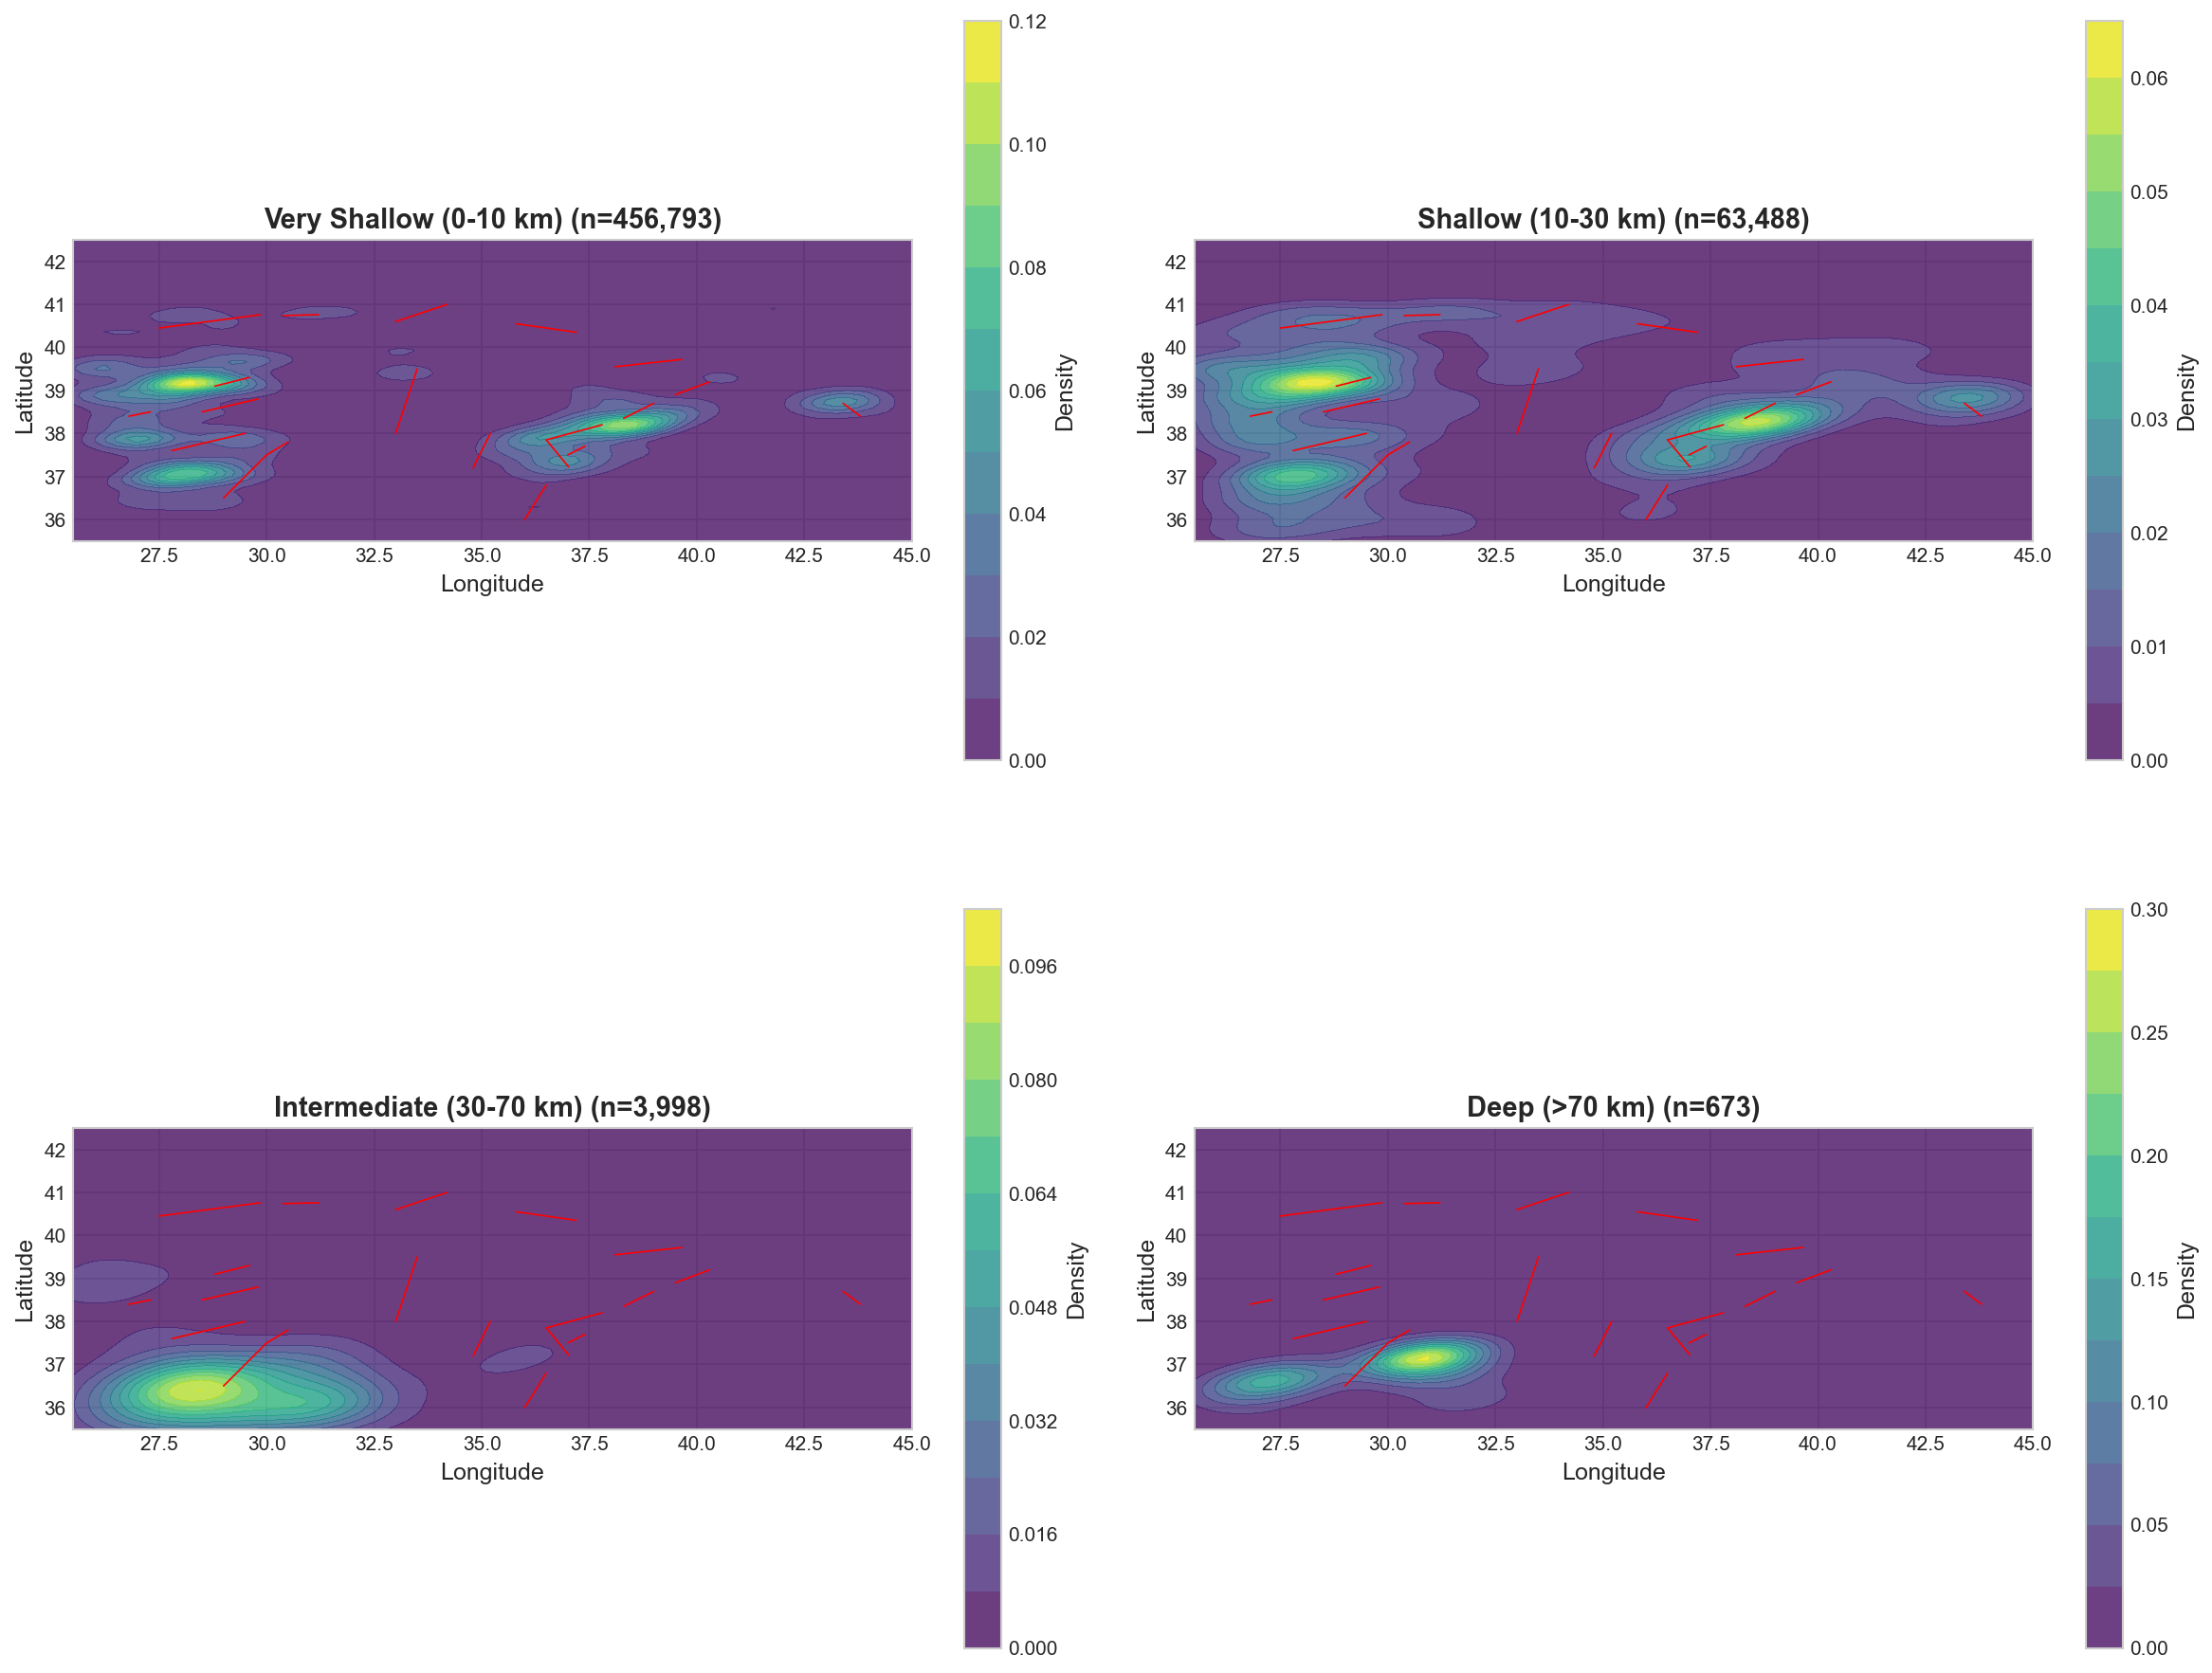

In [10]:
# KDE by depth class
depth_classes = [
    (0, 10, 'Very Shallow (0-10 km)'),
    (10, 30, 'Shallow (10-30 km)'),
    (30, 70, 'Intermediate (30-70 km)'),
    (70, 700, 'Deep (>70 km)')
]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for ax, (d_min, d_max, label) in zip(axes, depth_classes):
    subset = eq_df[(eq_df['depth'] >= d_min) & (eq_df['depth'] < d_max)]
    
    if len(subset) > 100:
        Xi, Yi, Zi, _ = compute_kde(
            subset['longitude'].values,
            subset['latitude'].values,
            resolution=80
        )
        
        ax = create_turkey_basemap(ax, f'{label} (n={len(subset):,})')
        c = ax.contourf(Xi, Yi, Zi, levels=12, cmap='viridis', alpha=0.8)
        plt.colorbar(c, ax=ax, label='Density', shrink=0.7)
    else:
        ax = create_turkey_basemap(ax, f'{label} (n={len(subset):,})')
        ax.scatter(subset['longitude'], subset['latitude'], s=10, alpha=0.5)
    
    plot_fault_lines(fault_df, ax=ax, color='red', linewidth=0.8, label=False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kde_by_depth.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Comparison: KDE vs Fault Lines

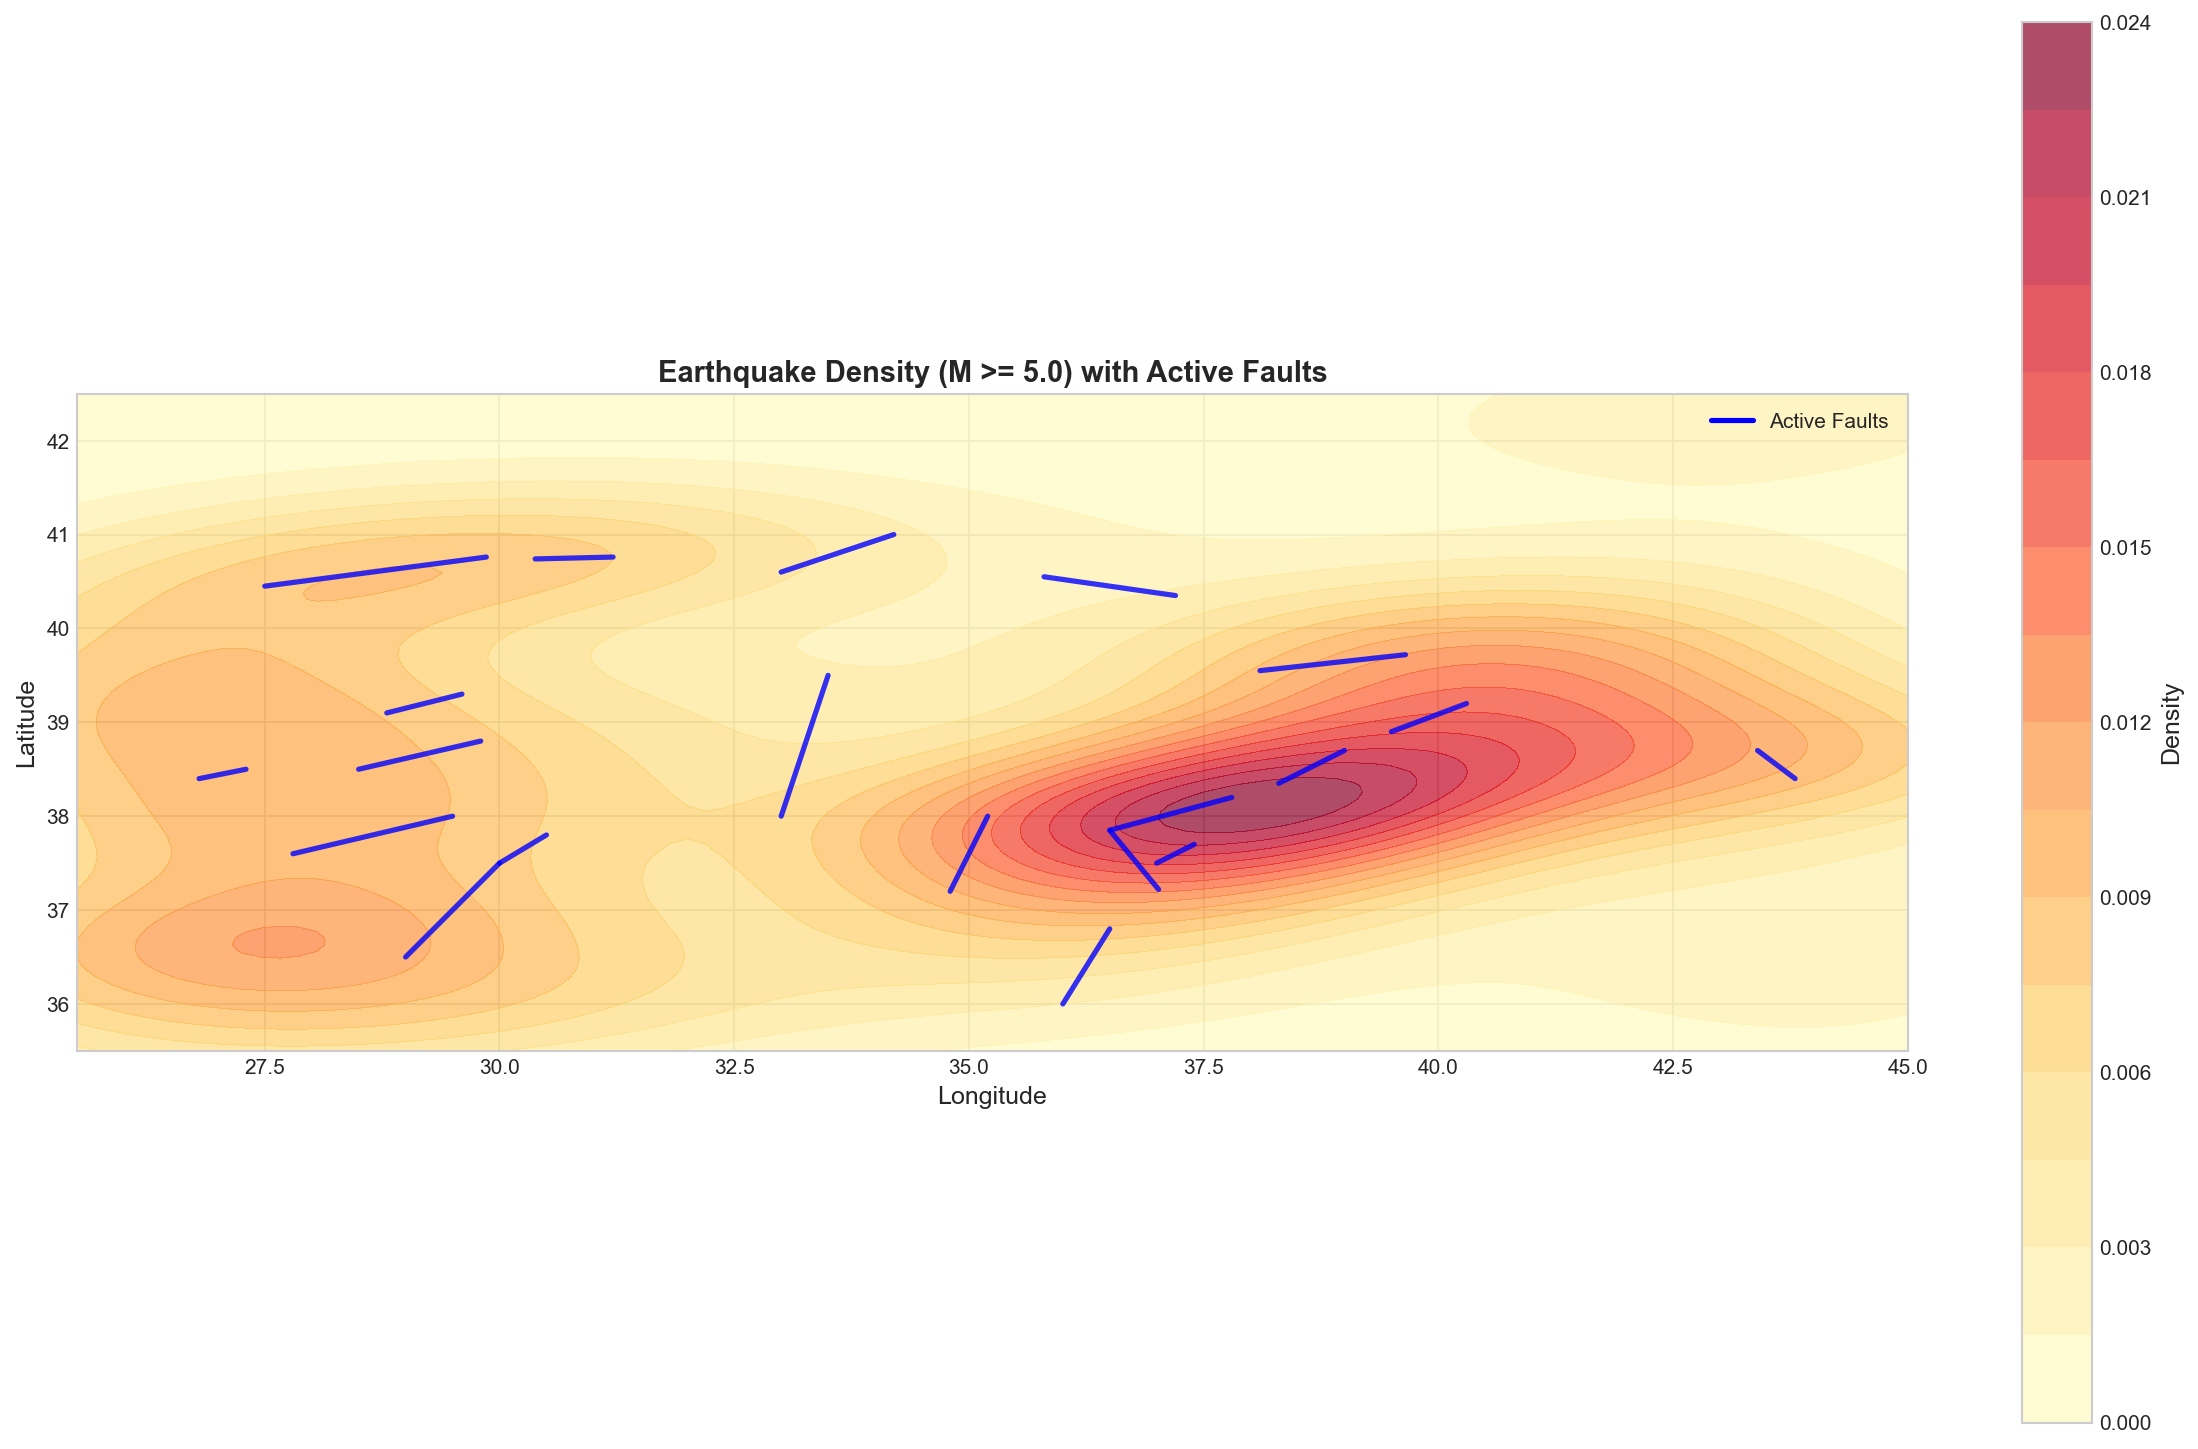

In [11]:
# Overlay KDE with fault lines prominently
fig, ax = plt.subplots(figsize=(16, 12))

# Compute KDE for significant earthquakes
sig_eq = eq_df[eq_df['magnitude'] >= 5.0]
Xi, Yi, Zi, _ = compute_kde(
    sig_eq['longitude'].values,
    sig_eq['latitude'].values,
    resolution=100
)

ax = create_turkey_basemap(ax, 'Earthquake Density (M >= 5.0) with Active Faults')

# KDE contours
c = ax.contourf(Xi, Yi, Zi, levels=15, cmap='YlOrRd', alpha=0.7)
plt.colorbar(c, ax=ax, label='Density', shrink=0.8)

# Fault lines (prominent)
for idx, fault in fault_df.iterrows():
    ax.plot([fault['lon_start'], fault['lon_end']], [fault['lat_start'], fault['lat_end']],
            color='blue', linewidth=2.5, zorder=10, alpha=0.8)

# Add fault name legend
ax.plot([], [], color='blue', linewidth=2.5, label='Active Faults')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'kde_with_faults.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Risk Hotspot Identification

In [12]:
# Identify high-density regions (hotspots)
# Use the KDE from significant earthquakes

# Define grid points for hotspot identification
xi = np.linspace(TURKEY_BOUNDS['lon_min'], TURKEY_BOUNDS['lon_max'], 50)
yi = np.linspace(TURKEY_BOUNDS['lat_min'], TURKEY_BOUNDS['lat_max'], 50)

# Create grid points
grid_points = []
for lon in xi:
    for lat in yi:
        grid_points.append((lon, lat))

# Evaluate KDE at grid points
grid_array = np.array(grid_points)
densities = kde_eq(grid_array.T)

# Find hotspots (top 10%)
threshold = np.percentile(densities, 90)
hotspot_mask = densities >= threshold
hotspots = grid_array[hotspot_mask]

print(f"Identified {len(hotspots)} grid cells as hotspots (top 10% density)")

Identified 250 grid cells as hotspots (top 10% density)


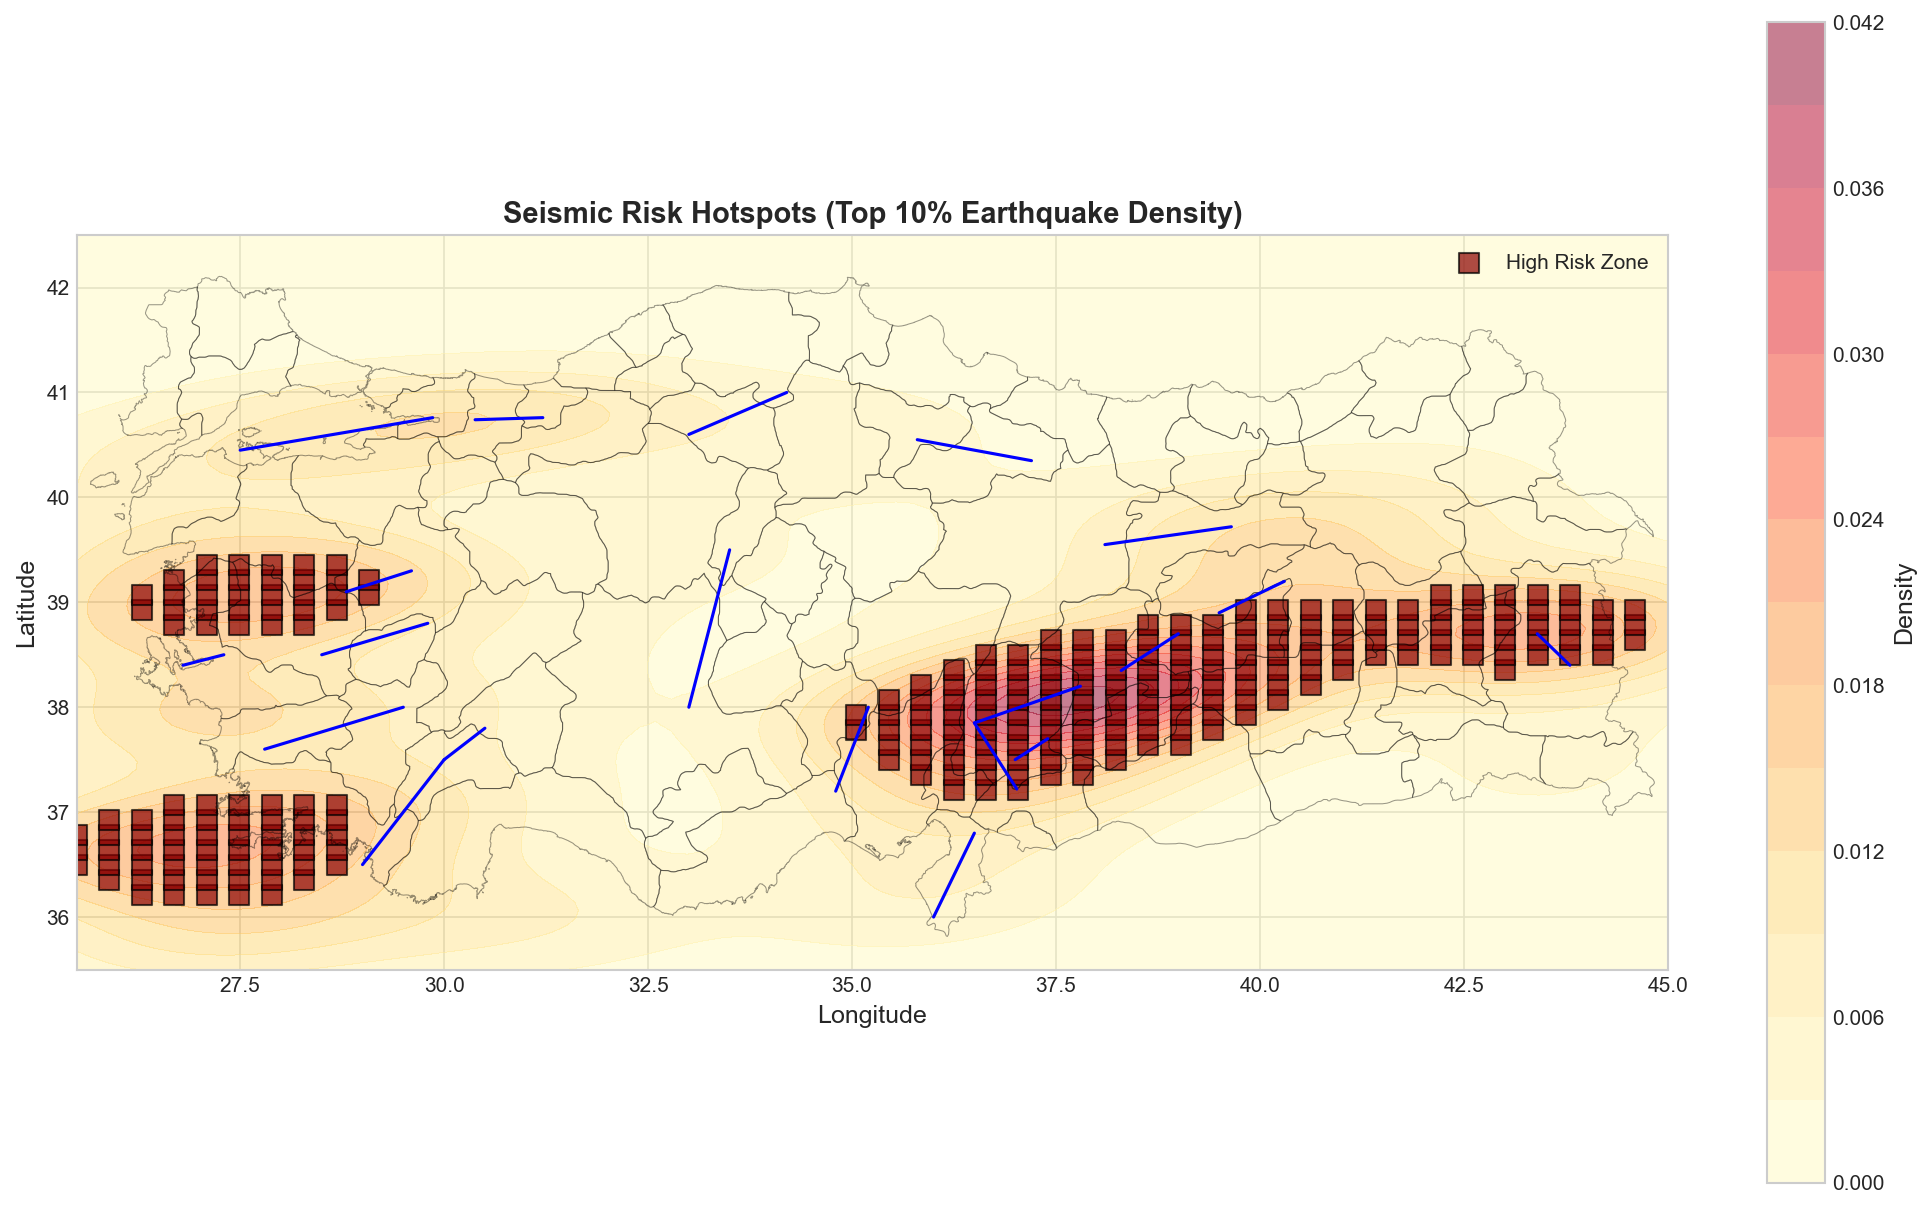

In [13]:
# Plot hotspots
fig, ax = plt.subplots(figsize=(14, 10))

ax = create_turkey_basemap(ax, 'Seismic Risk Hotspots (Top 10% Earthquake Density)')

# Background KDE
c = ax.contourf(Xi, Yi, Zi_eq, levels=15, cmap='YlOrRd', alpha=0.5)

# Hotspot markers
turkey_gdf.boundary.plot(ax=ax, linewidth=0.5, color='black', alpha=0.4, zorder=3)
ax.scatter(hotspots[:, 0], hotspots[:, 1], 
           s=100, c='darkred', marker='s', alpha=0.7, 
           label='High Risk Zone', edgecolors='black')

# Fault lines
plot_fault_lines(fault_df, ax=ax, color='blue', linewidth=1.5, label=False)

plt.colorbar(c, ax=ax, label='Density', shrink=0.8)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'risk_hotspots.png'), dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Summary statistics for hotspots
print("=" * 60)
print("HOTSPOT SUMMARY")
print("=" * 60)

# Center coordinates of hotspots
hotspot_center_lon = hotspots[:, 0].mean()
hotspot_center_lat = hotspots[:, 1].mean()

print(f"\nHotspot center: ({hotspot_center_lat:.2f}°N, {hotspot_center_lon:.2f}°E)")
print(f"Longitude range: {hotspots[:, 0].min():.2f}° to {hotspots[:, 0].max():.2f}°")
print(f"Latitude range: {hotspots[:, 1].min():.2f}° to {hotspots[:, 1].max():.2f}°")

# Count earthquakes in hotspot regions
from scipy.spatial.distance import cdist

eq_coords = eq_df[['longitude', 'latitude']].values
# Check which earthquakes are within 0.5 degrees of any hotspot
distances = cdist(eq_coords, hotspots)
in_hotspot = distances.min(axis=1) < 0.5

print(f"\nEarthquakes within hotspot regions: {in_hotspot.sum():,} ({in_hotspot.mean()*100:.1f}%)")

HOTSPOT SUMMARY

Hotspot center: (38.03°N, 35.24°E)
Longitude range: 25.50° to 44.60°
Latitude range: 36.21° to 39.36°



Earthquakes within hotspot regions: 320,107 (61.0%)


In [15]:
# Export hotspot data
hotspot_df = pd.DataFrame(hotspots, columns=['longitude', 'latitude'])
hotspot_df['density'] = densities[hotspot_mask]
hotspot_df = hotspot_df.sort_values('density', ascending=False)
hotspot_df.to_csv(os.path.join(TABLES_PATH, 'seismic_hotspots.csv'), index=False)

print(f"\nHotspot data exported to: {os.path.join(TABLES_PATH, 'seismic_hotspots.csv')}")


Hotspot data exported to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/seismic_hotspots.csv


In [16]:
print("\n" + "=" * 60)
print("KDE ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nFigures saved to: {OUTPUT_DIR}")


KDE ANALYSIS COMPLETE

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/03_kde
